In [127]:
import pandas as pd
import numpy as np
import time
import nba_api
import pandas.io.sql as psql

np.set_printoptions(suppress=True)

from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFE,f_regression, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import importnb

import import_ipynb
from database_interaction import nba_db

#Try this tomorrow for feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import silhouette_score # used as a metric to evaluate the cohesion in a cluster
from yellowbrick.cluster import KElbowVisualizer



#Try PCA for features before clustering
#Need to add 3 point field goals as data point

In [128]:
#Create instance of database
db = nba_db()

In [129]:
#Connect to database
db.connect_to_db()

successfully connected


In [130]:
#Pull players data
player_df = db.execute_query("SELECT * FROM players where season = '2016-17'")

In [131]:
#Close out connection
db.close_connection()

connection closed


In [132]:
#Fill missing percentages with 0 (likely because they didn't have any attempts
player_df['position'] = player_df['position'].fillna('unknown')
player_df = player_df.fillna(0)

In [133]:
player_df.isna().sum()

index                0
player_id            0
player_name          0
team_id              0
team_abbreviation    0
                    ..
corner_3_fgm         0
corner_3_fga         0
corner_3_fg_pct      0
salary               0
position             0
Length: 113, dtype: int64

In [134]:
player_df.columns[50:]

Index(['sp_work_off_rating_rank', 'e_def_rating_rank', 'def_rating_rank',
       'sp_work_def_rating_rank', 'e_net_rating_rank', 'net_rating_rank',
       'sp_work_net_rating_rank', 'ast_pct_rank', 'ast_to_rank',
       'ast_ratio_rank', 'oreb_pct_rank', 'dreb_pct_rank', 'reb_pct_rank',
       'tm_tov_pct_rank', 'e_tov_pct_rank', 'efg_pct_rank', 'ts_pct_rank',
       'usg_pct_rank', 'e_usg_pct_rank', 'e_pace_rank', 'pace_rank',
       'sp_work_pace_rank', 'pie_rank', 'fgm_rank', 'fga_rank', 'fgm_pg_rank',
       'fga_pg_rank', 'fg_pct_rank', 'season', 'fg2a_frequency', 'fg2m',
       'fg2a', 'fg2_pct', 'fg3a_frequency', 'fg3m', 'fg3a', 'fg3_pct',
       'restricted_area_fgm', 'restricted_area_fga', 'restricted_area_fg_pct',
       'in_the_paint_non_ra_fgm', 'in_the_paint_non_ra_fga',
       'in_the_paint_non_ra_fg_pct', 'mid_range_fgm', 'mid_range_fga',
       'mid_range_fg_pct', 'left_corner_3_fgm', 'left_corner_3_fga',
       'left_corner_3_fg_pct', 'right_corner_3_fgm', 'right_corne

In [135]:
player_df

,index,player_id,player_name,team_id,team_abbreviation,age,gp,w,l,w_pct,...,above_the_break_3_fga,above_the_break_3_fg_pct,backcourt_fgm,backcourt_fga,backcourt_fg_pct,corner_3_fgm,corner_3_fga,corner_3_fg_pct,salary,position
0,2744,1627773,aj hammons,1610612742,dal,24.0,22,4,18,0.182,...,8.0,0.625,0.0,0.0,0.0,0.0,2.0,0.000,650000.0,C
1,2745,201166,aaron brooks,1610612754,ind,32.0,65,36,29,0.554,...,106.0,0.396,0.0,6.0,0.0,6.0,15.0,0.400,2700000.0,G
2,2746,203932,aaron gordon,1610612753,orl,21.0,80,29,51,0.363,...,195.0,0.297,0.0,3.0,0.0,19.0,69.0,0.275,4351320.0,PF
3,2747,1626151,aaron harrison,1610612766,cha,22.0,5,2,3,0.400,...,1.0,0.000,0.0,0.0,0.0,0.0,1.0,0.000,874636.0,G
4,2748,203940,adreian payne,1610612750,min,26.0,18,5,13,0.278,...,13.0,0.231,0.0,0.0,0.0,0.0,2.0,0.000,2022240.0,PF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,3225,201163,wilson chandler,1610612743,den,30.0,71,35,36,0.493,...,244.0,0.357,0.0,1.0,0.0,23.0,81.0,0.284,11233146.0,SF
482,3226,1627812,yogi ferrell,1610612742,dal,24.0,46,18,28,0.391,...,152.0,0.395,0.0,1.0,0.0,8.0,23.0,0.348,0.0,unknown
483,3227,203897,zach lavine,1610612750,min,22.0,47,16,31,0.340,...,237.0,0.371,0.0,0.0,0.0,32.0,73.0,0.438,2240880.0,PG
484,3228,2216,zach randolph,1610612763,mem,35.0,73,38,35,0.521,...,75.0,0.227,0.0,5.0,0.0,4.0,14.0,0.286,10361445.0,F


In [165]:
#Create dataset for modeling
#Encode positions to numerical
labelencoder = LabelEncoder()
player_df['position_cat'] = labelencoder.fit_transform(player_df['position'])
player_df['position_cat'] = player_df['position_cat'].apply(float)

player_model_df = player_df.drop(['gp_rank',
'w_rank'                       ,
'l_rank'                       ,
'w_pct_rank'                   ,
'min_rank'                     ,
'e_off_rating_rank'            ,
'off_rating_rank'              ,
'sp_work_off_rating_rank'      ,
'e_def_rating_rank'            ,
'def_rating_rank'              ,
'sp_work_def_rating_rank'      ,
'e_net_rating_rank'            ,
'net_rating_rank'              ,
'sp_work_net_rating_rank'      ,
'ast_pct_rank'                 ,
'ast_to_rank'                  ,
'ast_ratio_rank'               ,
'oreb_pct_rank'                ,
'dreb_pct_rank'                ,
'reb_pct_rank'                 ,
'tm_tov_pct_rank'              ,
'e_tov_pct_rank'               ,
'efg_pct_rank'                 ,
'ts_pct_rank'                  ,
'usg_pct_rank'                 ,
'e_usg_pct_rank'               ,
'e_pace_rank'                  ,
'pace_rank'                    ,
'sp_work_pace_rank'            ,
'pie_rank'                     ,
'fgm_rank'                     ,
'fga_rank'                     ,
'fgm_pg_rank'                  ,
'fga_pg_rank'                  ,
'fg_pct_rank'                  ,
'sp_work_off_rating',
'sp_work_def_rating',
'sp_work_net_rating',
'off_rating',
'def_rating',
'net_rating',
 'season', 'player_id', 'player_name', 'team_id', 'team_abbreviation', 'w', 'l', 'position', 'salary'], axis = 1)


player_model_df = StandardScaler().fit_transform(player_model_df)

#Adjust by games played
testing_model = player_df[['e_def_rating', 'pie', 'e_off_rating', 'ast_to', 'e_pace', 'e_usg_pct',
                           'position_cat', 'ts_pct', 'fg2a', 'fg2_pct', 'fg3a', 'fg3_pct', 'in_the_paint_non_ra_fga' ,'in_the_paint_non_ra_fg_pct',
                          'corner_3_fga', 'corner_3_fg_pct', 'gp']].copy()

testing_model['fg2a'] = testing_model['fg2a'] / testing_model['gp']
testing_model['fg3a'] = testing_model['fg3a'] / testing_model['gp']
testing_model['corner_3_fga'] = testing_model['corner_3_fga'] / testing_model['gp']
testing_model['in_the_paint_non_ra_fga'] = testing_model['in_the_paint_non_ra_fga'] / testing_model['gp']
testing_model = testing_model.drop('gp', axis = 1)
testing_model_scaled = StandardScaler().fit_transform(testing_model)

In [166]:
testing_model

,e_def_rating,pie,e_off_rating,ast_to,e_pace,e_usg_pct,position_cat,ts_pct,fg2a,fg2_pct,fg3a,fg3_pct,in_the_paint_non_ra_fga,in_the_paint_non_ra_fg_pct,corner_3_fga,corner_3_fg_pct
0,102.8,0.043,102.2,0.40,95.66,0.167,0.0,0.472,1.227273,0.444,0.454545,0.500,0.227273,0.000,0.090909,0.000
1,104.5,0.062,101.5,1.89,96.54,0.191,2.0,0.507,2.384615,0.445,1.861538,0.380,0.646154,0.381,0.230769,0.400
2,108.2,0.088,105.4,1.69,99.71,0.200,3.0,0.530,6.937500,0.569,3.325000,0.289,1.037500,0.337,0.862500,0.275
3,101.9,0.000,83.3,0.00,92.43,0.142,2.0,0.102,0.400000,0.000,0.400000,0.000,0.000000,0.000,0.200000,0.000
4,102.2,0.081,102.6,0.88,96.68,0.224,3.0,0.505,2.111111,0.526,0.833333,0.200,0.333333,0.333,0.111111,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
481,111.8,0.098,110.1,1.24,100.42,0.221,5.0,0.545,8.014085,0.555,4.507042,0.338,2.352113,0.455,1.140845,0.284
482,108.3,0.084,104.2,2.46,95.89,0.196,7.0,0.533,4.282609,0.467,3.804348,0.389,0.826087,0.395,0.500000,0.348
483,110.1,0.095,106.5,1.64,96.39,0.218,4.0,0.576,7.744681,0.566,6.553191,0.390,0.659574,0.419,1.553191,0.438
484,105.2,0.152,104.1,1.23,94.38,0.285,1.0,0.490,10.986301,0.514,1.287671,0.223,3.054795,0.439,0.191781,0.286


In [167]:
#Use PCA to reduce the number of features
pca = PCA()
pca.fit(testing_model_scaled)

PCA()

In [168]:
len(pca.explained_variance_ratio_)

16

Text(0, 0.5, 'Cumulative Explained Variance')

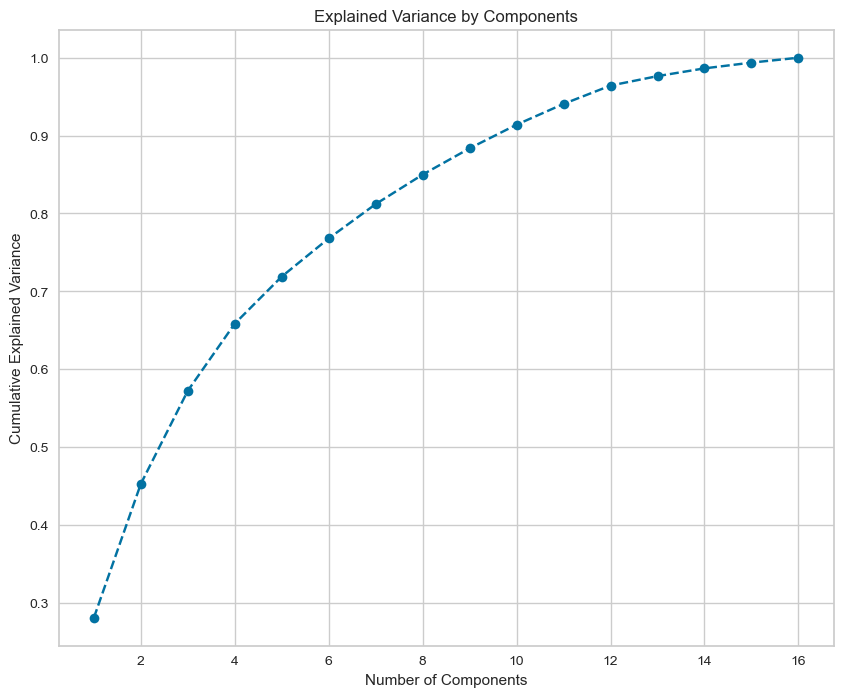

In [169]:
plt.figure(figsize = (10,8))
plt.plot(range(1,17), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [170]:
pca = PCA(n_components = 9)
pca.fit(player_model_df)

PCA(n_components=9)

In [171]:
pca.transform(player_model_df)

array([[-5.32280573,  0.12467379,  0.17696146, ..., -1.41528809,
        -1.18098144,  1.61406614],
       [-0.85189257, -1.97231496,  1.14030366, ..., -0.0768791 ,
        -0.39572359,  0.54364996],
       [ 4.12454204,  0.72526899,  0.11171736, ..., -0.23694818,
        -0.06533623, -1.16574993],
       ...,
       [ 4.78724501, -1.89156866, -0.17031259, ..., -1.60550514,
        -1.1193886 , -0.17635428],
       [ 3.92724126,  5.62555212,  3.51752441, ...,  0.81168167,
        -0.36715729, -0.03008306],
       [-2.49339847,  4.60409347, -2.35467583, ...,  1.79299454,
         2.8874925 ,  0.36725476]])

In [172]:
scores_pca = pca.transform(player_model_df)

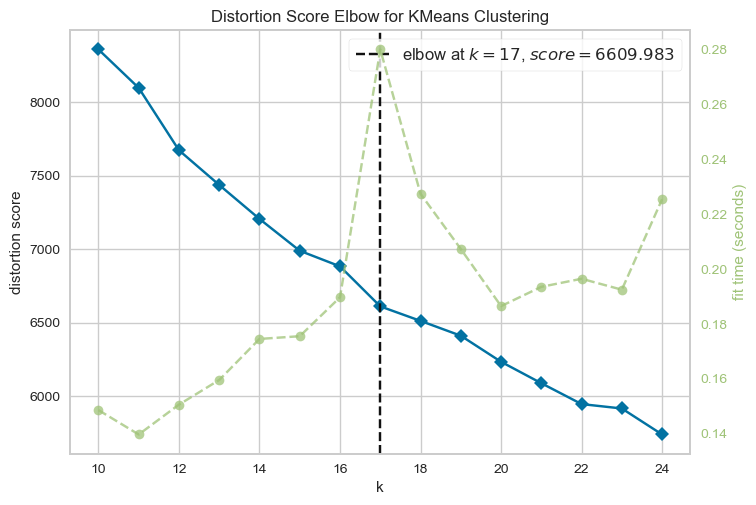

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [173]:
#Using the elbow method to figure out number of clusters
k_model = KMeans()
elbow_visual = KElbowVisualizer(k_model, k=(10,25))
elbow_visual.fit(scores_pca)
elbow_visual.show()

In [174]:
#try  DBSCAN clustering without salary first
clustering = DBSCAN(eps=2.5, min_samples=5).fit(scores_pca)


In [175]:
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [176]:
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 259


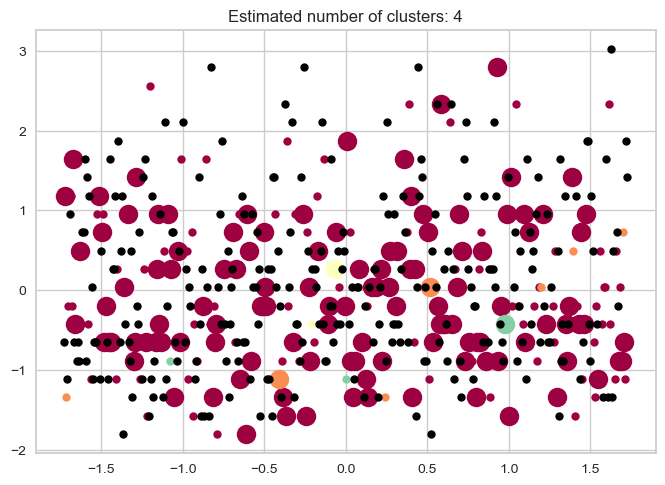

In [177]:
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = player_model_df[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = player_model_df[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [178]:
#Try K-Means clustering
k_means = KMeans(init = 'k-means++', n_clusters = 17)
label = k_means.fit_predict(scores_pca)

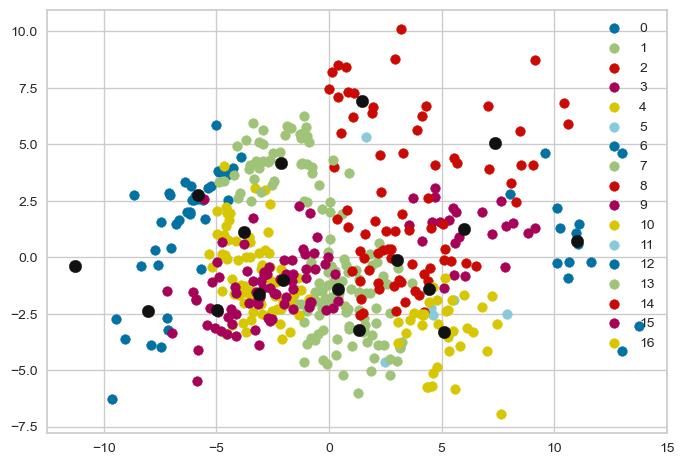

In [179]:
#Getting the Centroids
centroids = k_means.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
 
for i in u_labels:
    plt.scatter(scores_pca[label == i , 0] , scores_pca[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [180]:
cluster_map = pd.DataFrame()
cluster_map['name'] = player_df['player_name']
cluster_map['cluster'] = k_means.labels_

In [181]:
cluster_map[cluster_map['cluster'] == 2]#[:49]

,name,cluster
19,andre drummond,2
78,clint capela,2
105,deandre jordan,2
134,dwight howard,2
143,enes freedom,2
165,greg monroe,2
168,hassan whiteside,2
235,jonas valanciunas,2
250,julius randle,2
308,marcin gortat,2
